 Running on cuda
create mlp models: Training 20 mlps
 Got 20 valid SVD compressed layers.
 SELECTING SINGLE MODEL FOR OVERFIT TEST
training fab for overfit
   Ep 0 | Loss: 4.072056
   Ep 200 | Loss: 0.488085
   Ep 400 | Loss: 0.282968
   Ep 600 | Loss: 0.162109
   Ep 800 | Loss: 0.719936
   Ep 1000 | Loss: 0.133605
   Ep 1200 | Loss: 0.252897
   Ep 1400 | Loss: 0.050579
   Ep 1600 | Loss: 0.252685
   Ep 1800 | Loss: 0.143790
hypernet generating new model
   Reconstruction MSE vs original: 0.000064
   Testing Generated Feature Extractor
GENERATED MLP ACCURACY: 88.89%
worked the DiT memorized the structure!


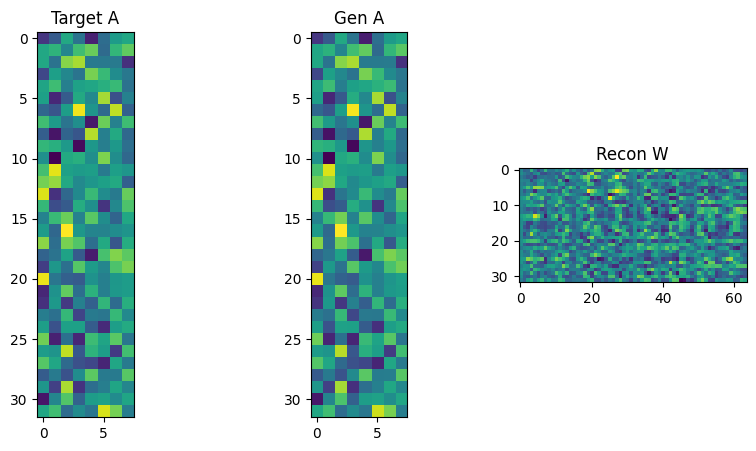

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import copy


class MicroMLP(nn.Module):
    def __init__(self, hidden_dim=32):
        super().__init__()
        self.fc1 = nn.Linear(64, hidden_dim) 
        self.fc2 = nn.Linear(hidden_dim, 10)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc1(x))
        return self.fc2(x)

def get_data():
    #oad the 8x8 digits 
    digits = load_digits()
    X = digits.data
    y = digits.target
    
    # standard scale
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return (torch.FloatTensor(X_train), torch.LongTensor(y_train), 
            torch.FloatTensor(X_test), torch.LongTensor(y_test))

def generate_model_farm(num_models=50):
    print(f"create mlp models: Training {num_models} mlps")
    X_train, y_train, X_test, y_test = get_data()
    
    dataset_A = [] # output neurons are rows x rank
    dataset_B = [] # input features are rank x columns
    
    # will compress layer 1 64 -> 32
    # shape now is [32, 64]
    # SVD Rank Target 8
    RANK = 8
    
    for i in range(num_models):
        model = MicroMLP()
        opt = optim.Adam(model.parameters(), lr=0.01)
        
        for ep in range(30): 
            opt.zero_grad()
            out = model(X_train)
            loss = F.cross_entropy(out, y_train)
            loss.backward()
            opt.step()
            
        # check model acc
        acc = (model(X_test).argmax(1) == y_test).float().mean()
        if acc < 0.85: continue # get rid of bad models
            
        # svd compress the model
        W = model.fc1.weight.data # [32, 64]
        
        # SVD
        U, S, Vh = torch.linalg.svd(W, full_matrices=False)
        
        # truncate  to Rank 8
        U_r = U[:, :RANK]
        S_r = S[:RANK]
        Vh_r = Vh[:RANK, :]
        
        # CANONICALIZE SIGNS data ordering is super important,
        # Ensure the largest element in each U column is positive.
        # this aligns all models to the same direction in latent space.
        for r in range(RANK):
            # find the index of max abs value
            idx = torch.argmax(torch.abs(U_r[:, r]))
            # if negative, flip both U and Vh (math stays same: -1 * -1 = 1)
            if U_r[idx, r] < 0:
                U_r[:, r] = U_r[:, r] * -1
                Vh_r[r, :] = Vh_r[r, :] * -1
        
        # Distribute Sigma for symmetry
        sqrt_S = torch.sqrt(S_r)
        
        # Matrix A [32, 8]
        mat_A = U_r * sqrt_S.unsqueeze(0)
        # Matrix B [8, 64]
        mat_B = sqrt_S.unsqueeze(1) * Vh_r
        
        dataset_A.append(mat_A)
        dataset_B.append(mat_B)
        
    print(f" Got {len(dataset_A)} valid SVD compressed layers.")
    return torch.stack(dataset_A), torch.stack(dataset_B), (X_test, y_test)

#simple coordinate dit that is could be used in a flow way

class FourierFeatures(nn.Module):
    def __init__(self, input_dim=2, embed_dim=64, scale=1.0):
        super().__init__()
        # adjusted scale to 1.0 for smoother low-freq features
        self.B = nn.Parameter(torch.randn(input_dim, embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        proj = (2 * torch.pi * x) @ self.B
        return torch.cat([torch.sin(proj), torch.cos(proj)], dim=-1)

class FruitFlyFabricator(nn.Module):
    def __init__(self, hidden_dim=256): 
        super().__init__()
        # (Row_Norm, Rank_Norm) -> Value
        self.coord_embed = FourierFeatures(2, hidden_dim, scale=5.0)
        
        self.input_proj = nn.Linear(1, hidden_dim) # noisy Value
        self.matrix_id_embed = nn.Embedding(2, hidden_dim) # Matrix A vs Matrix B
        self.time_embed = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Deep Residual MLP Block (Pre-Norm)
        # will be using a proper ResNet structure for better gradient flow
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm(hidden_dim),
                nn.SiLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.SiLU(),
                nn.Linear(hidden_dim, hidden_dim),
            ) for _ in range(3)
        ])
        
        self.final_norm = nn.LayerNorm(hidden_dim)
        self.output_head = nn.Linear(hidden_dim, 1)
        
        # Zero-init output for stability this might not be the move as weights are already close to 0 as the mean so will need experimentation
        nn.init.constant_(self.output_head.weight, 0)
        nn.init.constant_(self.output_head.bias, 0)

    def forward(self, x_t, coords, t, matrix_id):
        # Embed Spatial info and Noisy Value
        h = self.coord_embed(coords) + self.input_proj(x_t)
        
        # Embed Time and ID
        h_time = self.time_embed(t).unsqueeze(1)
        h_id = self.matrix_id_embed(matrix_id).unsqueeze(1)
        h = h + h_time + h_id
        
        # Residual Blocks
        for layer in self.layers:
            h = h + layer(h)
            
        h = self.final_norm(h)
        return self.output_head(h)


def run_fruit_fly():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f" Running on {device}")


    data_A, data_B, (X_test, y_test) = generate_model_farm(20) # Generate 20, but use 1
    
   
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    #just testing overfit to see if model can paint and the svd works need encoder and rnn to scale of course
    print(" SELECTING SINGLE MODEL FOR OVERFIT TEST")
    target_idx = 0

    data_A = data_A[target_idx:target_idx+1].repeat(16, 1, 1).to(device) 
    data_B = data_B[target_idx:target_idx+1].repeat(16, 1, 1).to(device)
    
    # normalize the data
    mean_A, std_A = data_A.mean(), data_A.std()
    mean_B, std_B = data_B.mean(), data_B.std()
    
    data_A = (data_A - mean_A) / std_A
    data_B = (data_B - mean_B) / std_B
    
    # prep coordinates
    # A: [32, 8], B: [8, 64] for the low rank matrixes
    def make_grid(rows, cols):
        r = torch.linspace(0, 1, rows)
        c = torch.linspace(0, 1, cols)
        grid_r, grid_c = torch.meshgrid(r, c, indexing='ij')
        return torch.stack([grid_r, grid_c], dim=-1).reshape(-1, 2)
        
    coords_A = make_grid(32, 8).to(device)  # [256, 2]
    coords_B = make_grid(8, 64).to(device)  # [512, 2]
    
    model = FruitFlyFabricator().to(device)
    opt = optim.AdamW(model.parameters(), lr=5e-4) 
    
    print("training fab for overfit")
    model.train()
    
    EPOCHS = 2000 #train long to memorize the matrixes will need to fix this prob
    for epoch in range(EPOCHS):
        opt.zero_grad()
        
        #matrix a train
        idx = torch.randint(0, len(data_A), (16,), device=device)
        target_A = data_A[idx].reshape(16, -1, 1) # [16, 256, 1]
        batch_coords_A = coords_A.unsqueeze(0).expand(16, -1, -1)
        
        t = torch.rand(16, 1, 1, device=device)
        noise = torch.randn_like(target_A)
        x_t = (1-t)*target_A + t*noise
        
        id_A = torch.zeros(16, dtype=torch.long, device=device)
        
        pred_A = model(x_t, batch_coords_A, t.squeeze(2), id_A)
        loss_A = F.mse_loss(pred_A, noise - target_A)
        
        #matrix b train
        target_B = data_B[idx].reshape(16, -1, 1)
        batch_coords_B = coords_B.unsqueeze(0).expand(16, -1, -1)
        
        t = torch.rand(16, 1, 1, device=device)
        noise = torch.randn_like(target_B)
        x_t = (1-t)*target_B + t*noise
        
        id_B = torch.ones(16, dtype=torch.long, device=device)
        
        pred_B = model(x_t, batch_coords_B, t.squeeze(2), id_B)
        loss_B = F.mse_loss(pred_B, noise - target_B)
        
        loss = loss_A + loss_B
        loss.backward()
        opt.step()
        
        if epoch % 200 == 0:
            print(f"   Ep {epoch} | Loss: {loss.item():.6f}")
            
    # have hypernet generate new model
    print("hypernet generating new model")
    model.eval()
    with torch.no_grad():
        # Generate A (Start at Noise / t=1.0)
        gen_A = torch.randn(1, 256, 1, device=device)
        steps = 50 # High precision integration
        dt = 1.0 / steps
        
        for i in range(steps):
            t_val = 1.0 - (i * dt) 
            t = torch.ones(1, 1, device=device) * t_val
            v = model(gen_A, coords_A.unsqueeze(0), t, torch.zeros(1, dtype=torch.long, device=device))
            gen_A = gen_A - v * dt 
            
        # Generate B
        gen_B = torch.randn(1, 512, 1, device=device)
        for i in range(steps):
            t_val = 1.0 - (i * dt)
            t = torch.ones(1, 1, device=device) * t_val
            v = model(gen_B, coords_B.unsqueeze(0), t, torch.ones(1, dtype=torch.long, device=device))
            gen_B = gen_B - v * dt

        # Denormalize
        gen_A = gen_A * std_A + mean_A
        gen_B = gen_B * std_B + mean_B
        
        # Reshape
        mat_A = gen_A.reshape(32, 8)
        mat_B = gen_B.reshape(8, 64)
        
        # Reconstruct Weight W = A @ B
        W_gen = torch.mm(mat_A, mat_B)
        
    # val test
    new_mlp = MicroMLP().to(device)
    with torch.no_grad():
        new_mlp.fc1.weight.copy_(W_gen)
        #check mse between weights 
        # W_orig = A_orig @ B_orig
        W_orig = torch.mm(data_A[0].reshape(32, 8) * std_A + mean_A, 
                          data_B[0].reshape(8, 64) * std_B + mean_B)
        
        mse_recon = F.mse_loss(W_gen, W_orig)
        print(f"   Reconstruction MSE vs original: {mse_recon.item():.6f}")
        
    print("   Testing Generated Feature Extractor")
    opt_check = optim.Adam(new_mlp.fc2.parameters(), lr=0.01) # Train only head
    
    # Train Head (Frozen Body)
    for _ in range(10):
        opt_check.zero_grad()
        out = new_mlp(X_test) 
        loss = F.cross_entropy(out, y_test)
        loss.backward()
        opt_check.step()
        
    acc = (new_mlp(X_test).argmax(1) == y_test).float().mean()
    print(f"GENERATED MLP ACCURACY: {acc.item():.2%}")
    
    if acc > 0.80:
        print("worked the DiT memorized the structure!")
    else:
        print("just noise blah")
        
    #plots
    plt.figure(figsize=(10, 5))
    plt.subplot(1,3,1); plt.title("Target A"); plt.imshow(data_A[0].cpu().reshape(32,8))
    plt.subplot(1,3,2); plt.title("Gen A"); plt.imshow(mat_A.cpu())
    plt.subplot(1,3,3); plt.title("Recon W"); plt.imshow(W_gen.cpu())
    plt.savefig("fruit_fly_results.png")

if __name__ == "__main__":
    run_fruit_fly()